In [2]:

import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
from torch_geometric.utils import from_smiles, to_networkx

import numpy as np
import networkx as nx
from typing import List, Optional
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import random
from typing import List
from tqdm.auto import trange
import re
import hashlib
import math
from functools import partial
from typing import List, Callable

import scipy.sparse as sparse

from scipy.sparse import coo_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc
from sklearn.cluster import SpectralClustering
import dask.dataframe as dd



In [3]:
"""General Estimator base class."""


class Estimator(object):
    """Estimator base class with constructor and public methods."""

    seed: int

    def __init__(self):
        """Creating an estimator."""
        pass

    def fit(self):
        """Fitting a model."""
        pass

    def get_embedding(self):
        """Getting the embeddings (graph or node level)."""
        pass

    def get_memberships(self):
        """Getting the membership dictionary."""
        pass

    def get_cluster_centers(self):
        """Getting the cluster centers."""
        pass
    
    def get_params(self):
        """Get parameter dictionary for this estimator.."""
        rx = re.compile(r'^\_')
        params = self.__dict__
        params = {key: params[key] for key in params if not rx.search(key)}
        return params

    def _set_seed(self):
        """Creating the initial random seed."""
        random.seed(self.seed)
        np.random.seed(self.seed)

    @staticmethod
    def _ensure_walk_traversal_conditions(graph: nx.classes.graph.Graph) -> nx.classes.graph.Graph:
        """Ensure walk traversal conditions."""
        for node_index in trange(
            graph.number_of_nodes(),
            # We do not leave the bar.
            leave=False,
            # We only show this bar when we can expect
            # for this process to take a bit of time.
            disable=graph.number_of_nodes() < 10_000,
            desc="Checking main diagonal existance",
            dynamic_ncols=True
        ):
            if not graph.has_edge(node_index, node_index):
                warnings.warn(
                    (
                        "Please do be advised that "
                        "the graph you have provided does not "
                        "contain (some) edges in the main "
                        "diagonal, for instance the self-loop "
                        "constitued of ({}, {}). These selfloops "
                        "are necessary to ensure that the graph "
                        "is traversable, and for this reason we "
                        "create a copy of the graph and add therein "
                        "the missing edges. Since we are creating "
                        "a copy, this will immediately duplicate "
                        "the memory requirements. To avoid this double "
                        "allocation, you can provide the graph with the selfloops."
                    ).format(
                        node_index,
                        node_index
                    )
                )
                # We create a copy of the graph
                graph = graph.copy()
                # And we add the missing edges
                # for filling the main diagonal
                graph.add_edges_from((
                    (index, index)
                    for index in range(graph.number_of_nodes())
                    if not graph.has_edge(index, index)
                ))
                break

        return graph

    @staticmethod
    def _check_indexing(graph: nx.classes.graph.Graph):
        """Checking the consecutive numeric indexing."""
        numeric_indices = [index for index in range(graph.number_of_nodes())]
        node_indices = sorted([node for node in graph.nodes()])

        assert numeric_indices == node_indices, "The node indexing is wrong."

    def _check_graph(self, graph: nx.classes.graph.Graph) -> nx.classes.graph.Graph:
        """Check the Karate Club assumptions about the graph."""
        self._check_indexing(graph)
        graph = self._ensure_walk_traversal_conditions(graph)

        return graph

    def _check_graphs(self, graphs: List[nx.classes.graph.Graph]):
        """Check the Karate Club assumptions for a list of graphs."""
        graphs = [self._check_graph(graph) for graph in graphs]

        return graphs
    
class WeisfeilerLehmanHashing(object):
    """
    Weisfeiler-Lehman feature extractor class.

    Args:
        graph (NetworkX graph): NetworkX graph for which we do WL hashing.
        wl_iterations (int): Number of WL iterations.
        use_node_attribute (Optional[str]): Optional attribute name to be used.
        erase_base_feature (bool): Deleting the base features.
    """

    def __init__(
        self,
        graph: nx.classes.graph.Graph,
        wl_iterations: int,
        use_node_attribute: Optional[str],
        erase_base_features: bool,
    ):
        """
        Initialization method which also executes feature extraction.
        """
        self.wl_iterations = wl_iterations
        self.graph = graph
        self.use_node_attribute = use_node_attribute
        self.erase_base_features = erase_base_features
        self._set_features()
        self._do_recursions()

    def _set_features(self):
        """
        Creating the features.
        """
        if self.use_node_attribute is not None:
            # We retrieve the features of the nodes with the attribute name
            # `feature` and assign them into a dictionary with structure:
            # {node_a_name: feature_of_node_a}
            # Nodes without this feature will not appear in the dictionary.
            features = nx.get_node_attributes(self.graph, self.use_node_attribute)

            # We check whether all nodes have the requested feature
            if len(features) != self.graph.number_of_nodes():
                missing_nodes = []
                # We find up to five missing nodes so to make
                # a more informative error message.
                for node in tqdm(
                    self.graph.nodes,
                    total=self.graph.number_of_nodes(),
                    leave=False,
                    dynamic_ncols=True,
                    desc="Searching for missing nodes"
                ):
                    if node not in features:
                        missing_nodes.append(node)
                    if len(missing_nodes) > 5:
                        break
                raise ValueError(
                    (
                        "We expected for ALL graph nodes to have a node "
                        "attribute name `{}` to be used as part of "
                        "the requested embedding algorithm, but only {} "
                        "out of {} nodes has the correct attribute. "
                        "Consider checking for typos and missing values, "
                        "and use some imputation technique as necessary. "
                        "Some of the nodes without the requested attribute "
                        "are: {}"
                    ).format(
                        self.use_node_attribute,
                        len(features),
                        self.graph.number_of_nodes(),
                        missing_nodes
                    )
                )
            # If so, we assign the feature set.
            self.features = features
        else:
            self.features = {
                node: self.graph.degree(node) for node in self.graph.nodes()
            }
        self.extracted_features = {k: [str(v)]
                                   for k, v in self.features.items()}

    def _erase_base_features(self):
        """
        Erasing the base features
        """
        for k, v in self.extracted_features.items():
            del self.extracted_features[k][0]

    def _do_a_recursion(self):
        """
        The method does a single WL recursion.

        Return types:
            * **new_features** *(dict of strings)* - The hash table with extracted WL features.
        """
        new_features = {}
        for node in self.graph.nodes():
            nebs = self.graph.neighbors(node)
            degs = [self.features[neb] for neb in nebs]
            features = [str(self.features[node])] + \
                sorted([str(deg) for deg in degs])
            features = "_".join(features)
            hash_object = hashlib.md5(features.encode())
            hashing = hash_object.hexdigest()
            new_features[node] = hashing
        self.extracted_features = {
            k: self.extracted_features[k] + [v] for k, v in new_features.items()
        }
        return new_features

    def _do_recursions(self):
        """
        The method does a series of WL recursions.
        """
        for _ in range(self.wl_iterations):
            self.features = self._do_a_recursion()
        if self.erase_base_features:
            self._erase_base_features()

    def get_node_features(self):
        """
        Return the node level features.
        """
        return self.extracted_features

    def get_graph_features(self) -> List[str]:
        """
        Return the graph level features.
        """
        return [
            feature
            for node, features in self.extracted_features.items()
            for feature in features
        ]

class Graph2Vec(Estimator):
    r"""An implementation of `"Graph2Vec" <https://arxiv.org/abs/1707.05005>`_
    from the MLGWorkshop '17 paper "Graph2Vec: Learning Distributed Representations of Graphs".
    The procedure creates Weisfeiler-Lehman tree features for nodes in graphs. Using
    these features a document (graph) - feature co-occurrence matrix is decomposed in order
    to generate representations for the graphs.

    The procedure assumes that nodes have no string feature present and the WL-hashing
    defaults to the degree centrality. However, if the parameter `use_node_attribute` is
    provided, the feature extraction happens based on the values of this key.

    Args:
        wl_iterations (int): Number of Weisfeiler-Lehman iterations. Default is 2.
        use_node_attribute (Optional[str]): The optional parameter from which to load node features. Default is None..
        dimensions (int): Dimensionality of embedding. Default is 128.
        workers (int): Number of cores. Default is 4.
        down_sampling (float): Down sampling frequency. Default is 0.0001.
        epochs (int): Number of epochs. Default is 10.
        learning_rate (float): HogWild! learning rate. Default is 0.025.
        min_count (int): Minimal count of graph feature occurrences. Default is 5.
        seed (int): Random seed for the model. Default is 42.
        erase_base_features (bool): Erasing the base features. Default is False.
    """

    def __init__(
        self,
        wl_iterations: int = 2,
        use_node_attribute: Optional[str] = None,
        dimensions: int = 128,
        workers: int = 4,
        down_sampling: float = 0.0001,
        epochs: int = 10,
        learning_rate: float = 0.025,
        min_count: int = 5,
        seed: int = 42,
        erase_base_features: bool = False,
    ):

        self.wl_iterations = wl_iterations
        self.use_node_attribute = use_node_attribute
        self.dimensions = dimensions
        self.workers = workers
        self.down_sampling = down_sampling
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.min_count = min_count
        self.seed = seed
        self.erase_base_features = erase_base_features

    def fit(self, graphs: List[nx.classes.graph.Graph]):
        """
        Fitting a Graph2Vec model.

        Arg types:
            * **graphs** *(List of NetworkX graphs)* - The graphs to be embedded.
        """
        self._set_seed()
        graphs = self._check_graphs(graphs)
        documents = [
            WeisfeilerLehmanHashing(
                graph=graph,
                wl_iterations=self.wl_iterations,
                use_node_attribute=self.use_node_attribute,
                erase_base_features=self.erase_base_features,
            )
            for graph in graphs
        ]
        documents = [
            TaggedDocument(words=doc.get_graph_features(), tags=[str(i)])
            for i, doc in enumerate(documents)
        ]

        self.model = Doc2Vec(
            documents,
            vector_size=self.dimensions,
            window=0,
            min_count=self.min_count,
            dm=0,
            sample=self.down_sampling,
            workers=self.workers,
            epochs=self.epochs,
            alpha=self.learning_rate,
            seed=self.seed,
        )

        self._embedding = [self.model.dv[str(i)] for i, _ in enumerate(documents)]

    def get_embedding(self) -> np.array:
        r"""Getting the embedding of graphs.

        Return types:
            * **embedding** *(Numpy array)* - The embedding of graphs.
        """
        return np.array(self._embedding)

    def infer(self, graphs) -> np.array:
        """Infer the graph embeddings.
    
        Arg types:
            * **graphs** *(List of NetworkX graphs)* - The graphs to be embedded.

        Return types:
            * **embedding** *(Numpy array)* - The embedding of graphs.
        """
        self._set_seed()
        graphs = self._check_graphs(graphs)
        documents = [
            WeisfeilerLehmanHashing(
                graph=graph,
                wl_iterations=self.wl_iterations,
                use_node_attribute=self.use_node_attribute,
                erase_base_features=self.erase_base_features,
            )
            for graph in graphs
        ]

        documents = [doc.get_graph_features() for _, doc in enumerate(documents)]

        embedding = np.array(
            [
                self.model.infer_vector(
                    doc, alpha=self.learning_rate, min_alpha=0.00001, epochs=self.epochs
                )
                for doc in documents
            ]
        )

        return embedding

Due to the fact that KarateClub uses old versions of pandas and numpy (numpy->1.22.0 < numpy -> 1.26.0), we obtained the code from (https://github.com/benedekrozemberczki/karateclub/tree/master) to use the module Graph Embedding and applied the necessary classes for it to work (estimators). 
We obtained the graphs of antidepressant drugs (ATC N06A, file "./Antidepressives.csv") using ISOMERIC SMILES (used Pubchem API to obtain isomeric smiles, script "./pubchem_smiles.py") (<a href="http://sideeffects.embl.de/drugs/">link to substances</a>).


In [4]:




def _weighted_directed_degree(node: int, graph: nx.classes.graph.Graph) -> float:
    out = graph.degree(node, weight="weight")

    return out


def _unweighted_undirected_degree(node: int, graph: nx.classes.graph.Graph) -> float:
    out = graph.degree[node]

    return float(out)


def _get_degree_fn(graph) -> Callable:
    """Gets the function to calculate the graph node degree"""
    fn = (
        _weighted_directed_degree
        if nx.classes.function.is_weighted(graph)
        else _unweighted_undirected_degree
    )
    fn = partial(fn, graph=graph)

    return fn



class FeatherGraph(Estimator):
    r"""An implementation of `"FEATHER-G" <https://arxiv.org/abs/2005.07959>`_
    from the CIKM '20 paper "Characteristic Functions on Graphs: Birds of a Feather,
    from Statistical Descriptors to Parametric Models". The procedure
    uses characteristic functions of node features with random walk weights to describe
    node neighborhoods. These node level features are pooled by mean pooling to
    create graph level statistics.

    Args:
        order (int): Adjacency matrix powers. Default is 5.
        eval_points (int): Number of evaluation points. Default is 25.
        theta_max (int): Maximal evaluation point value. Default is 2.5.
        seed (int): Random seed value. Default is 42.
        pooling (str): Permutation invariant pooling function, one of:
                       (:obj:`"mean"`, :obj:`"max"`, :obj:`"min"`). Default is "mean."
    """
    n_nodes: int
    degree_fn: Callable
    _embedding: List[np.ndarray]

    def __init__(
        self,
        order: int = 5,
        eval_points: int = 25,
        theta_max: float = 2.5,
        seed: int = 42,
        pooling: str = "mean",
    ):
        super(FeatherGraph, self).__init__()

        self.order = order
        self.eval_points = eval_points
        self.theta_max = theta_max
        self.seed = seed

        try:
            pool_fn = getattr(np, pooling)
        except AttributeError:
            raise ValueError(f"{pooling.__repr__()} is not a valid pooling function")

        self.pooling = pooling
        self.pool_fn = partial(pool_fn, axis=0)

    def _create_d_inverse(self) -> sparse.coo_matrix:
        """
        Creating a sparse inverse degree matrix.

        Arg types:
            * **graph** *(NetworkX graph)* - The graph to be embedded.

        Return types:
            * **D_inverse** *(Scipy array)* - Diagonal inverse degree matrix.
        """
        index = np.arange(self.n_nodes)
        values = np.array(
            [1.0 / self.degree_fn(node) for node in range(self.n_nodes)]
        )  # <- ?

        shape = (self.n_nodes, self.n_nodes)
        D_inverse = sparse.coo_matrix((values, (index, index)), shape=shape)
        return D_inverse

    def _get_normalized_adjacency(
        self, graph: nx.classes.graph.Graph
    ) -> sparse.coo_matrix:
        """
        Calculating the normalized adjacency matrix.

        Arg types:
            * **graph** *(NetworkX graph)* - The graph of interest.

        Return types:
            * **A_hat** *(SciPy array)* - The scattering matrix of the graph.
        """
        A = nx.adjacency_matrix(graph, nodelist=range(self.n_nodes))
        D_inverse = self._create_d_inverse()

        A_hat = D_inverse.dot(A)
        return A_hat

    def _create_node_feature_matrix(self, graph: nx.classes.graph.Graph) -> np.ndarray:
        """
        Calculating the node features.

        Arg types:
            * **graph** *(NetworkX graph)* - The graph of interest.

        Return types:
            * **X** *(NumPy array)* - The node features.
        """
        log_degree = np.array(
            [math.log(self.degree_fn(node) + 1) for node in range(self.n_nodes)]
        )
        log_degree = log_degree.reshape(-1, 1)

        clustering_coefficient = np.array(
            [nx.clustering(graph, node) for node in range(self.n_nodes)]
        )
        clustering_coefficient = clustering_coefficient.reshape(-1, 1)

        X = np.concatenate([log_degree, clustering_coefficient], axis=1)
        return X

    def _calculate_feather(self, graph: nx.classes.graph.Graph) -> np.ndarray:
        """
        Calculating the characteristic function features of a graph.

        Arg types:
            * **graph** *(NetworkX graph)* - A graph to be embedded.

        Return types:
            * **features** *(Numpy vector)* - The embedding of a single graph.
        """
        self.n_nodes = graph.number_of_nodes()
        self.degree_fn = _get_degree_fn(graph)

        A_tilde = self._get_normalized_adjacency(graph)
        X = self._create_node_feature_matrix(graph)
        theta = np.linspace(0.01, self.theta_max, self.eval_points)

        X = np.outer(X, theta)
        X = X.reshape(graph.number_of_nodes(), -1)
        X = np.concatenate([np.cos(X), np.sin(X)], axis=1)

        feature_blocks = []
        for _ in range(self.order):
            X = A_tilde.dot(X)
            feature_blocks.append(X)

        feature_blocks = np.concatenate(feature_blocks, axis=1)
        feature_blocks = self.pool_fn(feature_blocks)

        return feature_blocks

    def fit(self, graphs: List[nx.classes.graph.Graph]) -> None:
        """
        Fitting a graph level FEATHER model.

        Arg types:
            * **graphs** *(List of NetworkX graphs)* - The graphs to be embedded.
        """
        self._set_seed()
        graphs = self._check_graphs(graphs)
        self._embedding = [self._calculate_feather(graph) for graph in graphs]


    def get_embedding(self) -> np.array:
        r"""Getting the embedding of graphs.

        Return types:
            * **embedding** *(Numpy array)* - The embedding of graphs.
        """
        return np.array(self._embedding)

    def infer(self, graphs: List[nx.classes.graph.Graph]) -> np.array:
        """
        Inferring graph embeddings with a graph level FEATHER model.

        Arg types:
            * **graphs** *(List of NetworkX graphs)* - The graphs to be embedded.

        Return types:
            * **embedding** *(Numpy array)* - The embedding of graphs.
        """
        self._set_seed()
        graphs = self._check_graphs(graphs)
        embedding = np.array([self._calculate_feather(graph) for graph in graphs])
        return embedding

We used graph embedding to change the smiles (Obtained using script pubchem_smiles.py with output file ->"./data/smiles.csv") into graphs using a module from Pytorch Geometric (https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/utils/smiles.html). Then transformed in vectors of dimension D=26. To do that, we used Graph2Vec (https://arxiv.org/abs/1707.05005) for ML (Random Forest and XGBoost) and Feather Graph (D = 500)for clustering (https://arxiv.org/pdf/2005.07959).


In [5]:
table_Antidepressants = pd.read_csv("./data/smiles.csv", sep=",", index_col=False)
table_Antidepressants = table_Antidepressants.sort_values("Name")
smiles = table_Antidepressants['Isomeric']
print(table_Antidepressants)

def t_smiles(smile): 
    return to_networkx(from_smiles(smile), to_undirected=True)
#decided on using D=26 as it worked the best when using linear regression without having any colinearity.
n_emb = 26
Graphs = list(map(t_smiles, smiles))
g_mdl = Graph2Vec(dimensions=n_emb)
Graphs = list(map(t_smiles, smiles))
g2_mdl = FeatherGraph()
g_mdl.fit(Graphs)
g2_mdl.fit(Graphs)
g_emb = g_mdl.get_embedding()
g2_emb = g2_mdl.get_embedding()

x_1 = g_emb


               Name                                           Isomeric  \
1       alaproclate                 CC(C(=O)OC(C)(C)CC1=CC=C(C=C1)Cl)N   
19    amitriptyline               CN(C)CCC=C1C2=CC=CC=C2CCC3=CC=CC=C31   
11        amoxapine         C1CN(CCN1)C2=NC3=CC=CC=C3OC4=C2C=C(C=C4)Cl   
7        bifemelane                     CNCCCCOC1=CC=CC=C1CC2=CC=CC=C2   
20        bupropion                  CC(C(=O)C1=CC(=CC=C1)Cl)NC(C)(C)C   
0      clomipramine            CN(C)CCCN1C2=CC=CC=C2CCC3=C1C=C(C=C3)Cl   
2       desipramine                   CNCCCN1C2=CC=CC=C2CCC3=CC=CC=C31   
26       dibenzepin          CN1C2=CC=CC=C2C(=O)N(C3=CC=CC=C31)CCN(C)C   
23        dosulepin            CN(C)CC/C=C/1\C2=CC=CC=C2CSC3=CC=CC=C31   
4           doxepin            CN(C)CC/C=C/1\C2=CC=CC=C2COC3=CC=CC=C31   
15       duloxetine          CNCC[C@@H](C1=CC=CS1)OC2=CC=CC3=CC=CC=C32   
27     escitalopram  CN(C)CCC[C@@]1(C2=C(CO1)C=C(C=C2)C#N)C3=CC=C(C...   
17       fluoxetine           CNCCC(C1

In this part, we used the vectors obtained with FeatherGraph, as it showed better results for clustering. 
We used the elbow method (for both Graph2Vec and FeatherGraph) and hierarchical clustering to define the quantity of clusters that we are going to consider. 

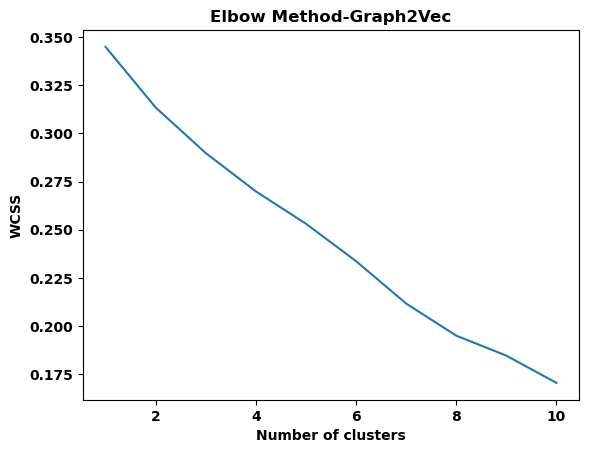

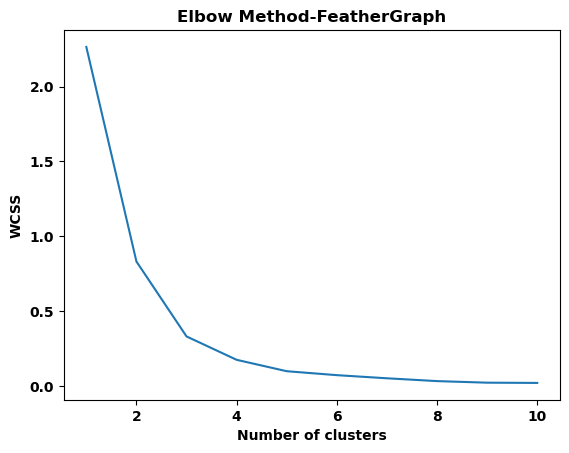

In [6]:

wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init="k-means++", max_iter=300, n_init=10, random_state=2)
    kmeans.fit(g_emb)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11), wcss)
plt.title("Elbow Method-Graph2Vec")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.savefig("./img/elbow_graph2vec.png")
plt.show()
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init="k-means++", max_iter=300, n_init=10, random_state=2)
    kmeans.fit(g2_emb)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11), wcss)
plt.title("Elbow Method-FeatherGraph")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.savefig("./img/elbow_feathergraph.png")
plt.show()

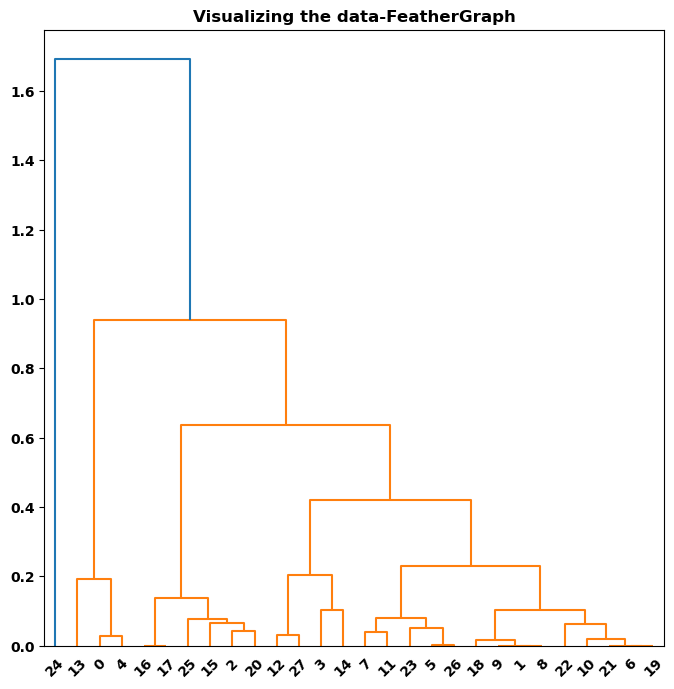

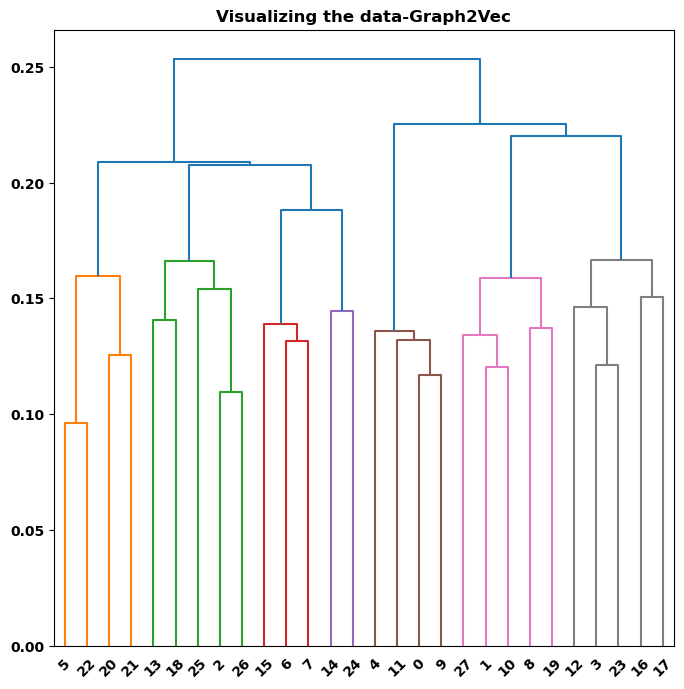

In [7]:

plt.figure(figsize = (8,8))
plt.title('Visualizing the data-FeatherGraph')
Dendogram = shc.dendrogram((shc.linkage(g2_emb, method="ward")))
plt.savefig("./img/hierarchy_feathergraph.png")

plt.figure(figsize = (8,8))
plt.title('Visualizing the data-Graph2Vec')
Dendogram = shc.dendrogram((shc.linkage(g_emb, method="ward")))
plt.savefig("./img/hierarchy_graph2vec.png")

We realized spectral clustering (n=2) and labeled each one of the drugs to divide into clusters. We also used PRR to observe the number of incidents using the data from FAERS. 
The input for this spectral clustering model, are the graph embeddings obtained from Feather Graph (since it showed better results with the elbow method).

We generated the prr data (ppr.csv) with the script sql_prr.py. This script considers the access of a remote database which is not accesible to the public, but it is the same data provided by FAERS (2014Q3- 2023 Q4). 

The heatmap represent the value of the PRR of the drug with each ADR.
<table>
    <tr>
        <th>variable name</th>
        <th>type</th>
        <th>Explanation</th>
    </tr>
    <tr>
        <td>g2_emb</td>
        <td>ndarray
        </td>
        <td>graph embedding using FeatherGraph D=500</td>
    </tr>
    <tr>
        <td>table_Antidepressants</td>
        <td>dataframe
        {</br>
            &emsp;"Name": str</br>
            &emsp;"Isomeric": str</br>
            &emsp;"Canonical": str</br>
        }
        </td>
        <td>Dataframe with basic information of 28 antidepressants: name of drug and smiles (isomeric, canonical)</td>
    </tr>
</table> 

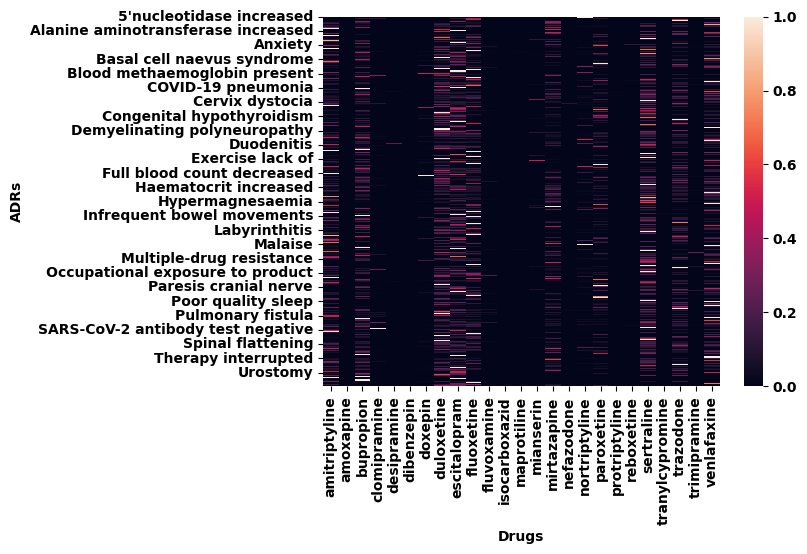

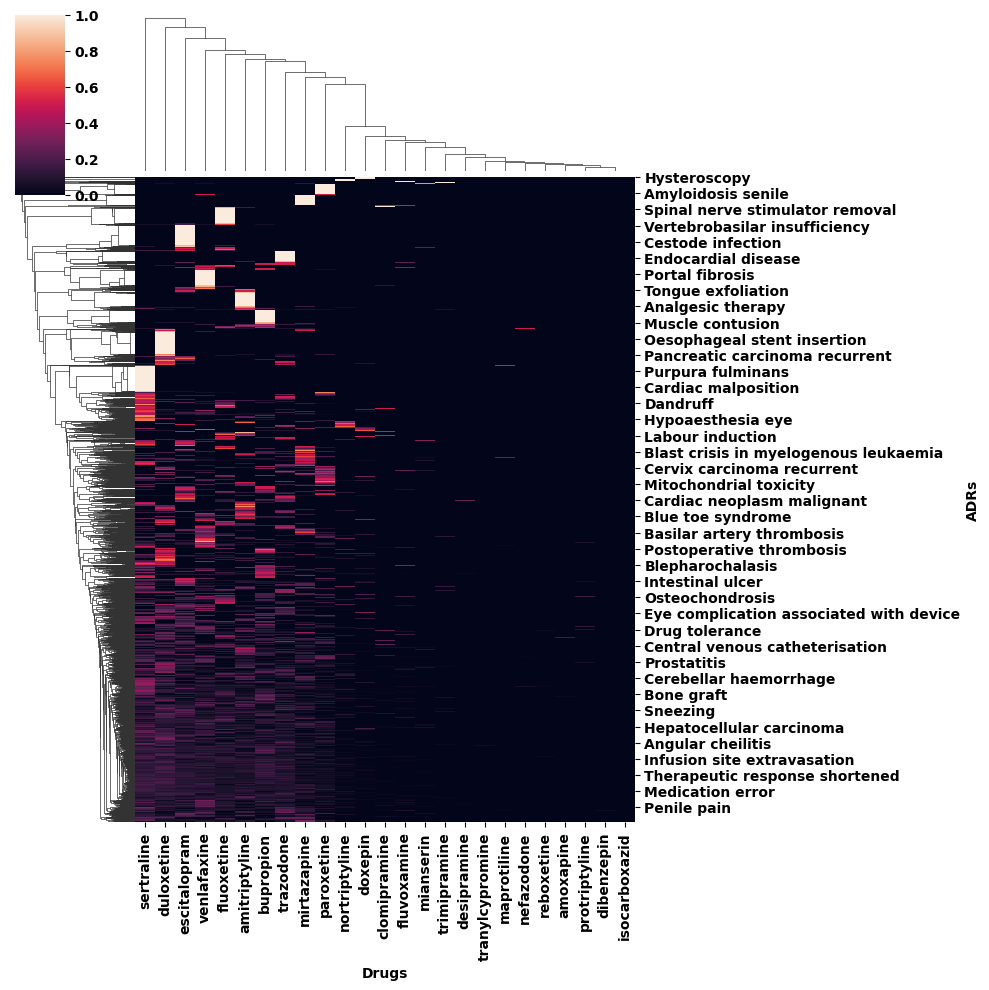

In [8]:
no_clusters = 2

clustering = SpectralClustering(n_clusters=no_clusters,
        assign_labels='discretize',
        random_state=0, affinity ='rbf').fit(g2_emb)


labels_cluster = clustering.fit_predict(g2_emb)
classification_chemicals=pd.DataFrame({"prod_ai":table_Antidepressants['Name'], "Label":labels_cluster})

classification_chemicals.to_csv("./data/cluster_label.csv", index=False)

df_cchemicals = dd.from_pandas(classification_chemicals)
df_prr = dd.read_csv("prr.csv/*.part")
df_prr_drugs = dd.merge(df_cchemicals, df_prr, on='prod_ai', how='inner').compute()



result_1 = df_prr_drugs.pivot(index='pt', columns='prod_ai', values='prr')
result_1.fillna(0, inplace=True)


import seaborn as sns
ax = sns.heatmap(result_1)
ax.set_ylabel("ADRs")
ax.set_xlabel("Drugs")
plt.savefig("./img/heatmap_adr_drugs.png", bbox_inches='tight')
g = sns.clustermap(result_1)
g.ax_heatmap.set_ylabel("ADRs")
g.ax_heatmap.set_xlabel("Drugs")
plt.savefig("./img/clustermap_adr_drugs.png", bbox_inches='tight')

Using the data obtained from SpectralClustering on the cell above, we labelled the drugs to one of two clusters. These clusters were then plotted in a heatmap and clustermap, to show if the clusters show any difference between each other regarding their ADRs. As one of the objectives of the project was to check if the chemical structure defines the ADRs of the drugs. 
<table>
    <tr>
        <th>variable name</th>
        <th>type</th>
        <th>Explanation</th>
    </tr>
    <tr>
        <td>df_prr_drugs</td>
        <td>dataframe
        {</br>
            &emsp;"prod_ai": str, antidepressant's name</br>
            &emsp;"Label": int, label (group) of drug</br>
            &emsp;"pt": str, Adverse Drug reaction in preferred terms (MEDRA)</br>
            &emsp;"no_reactions": int, number of reports done for that ADR and drug</br>
            &emsp;"total": int, number of reports done in total for that ADR considering all the antidepressants</br>
            &emsp;"prr": float, PRR for that ADR and antidepressant</br>
        }
        </td>
        <td>Dataframe with information of the relation between each drug and its ADR</td>
    </tr>
</table> 

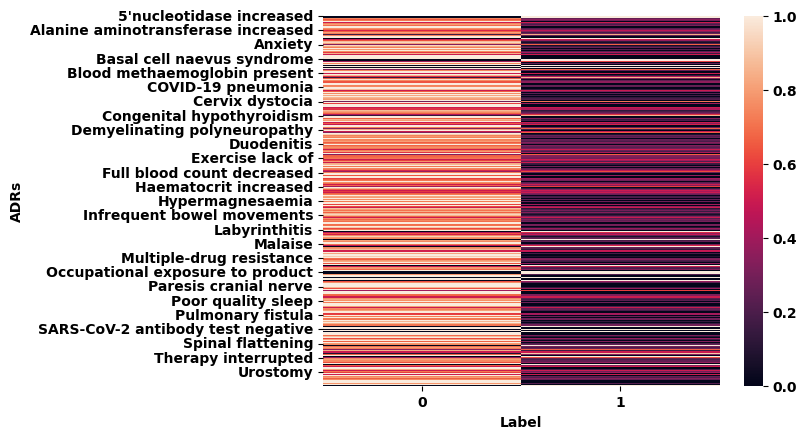

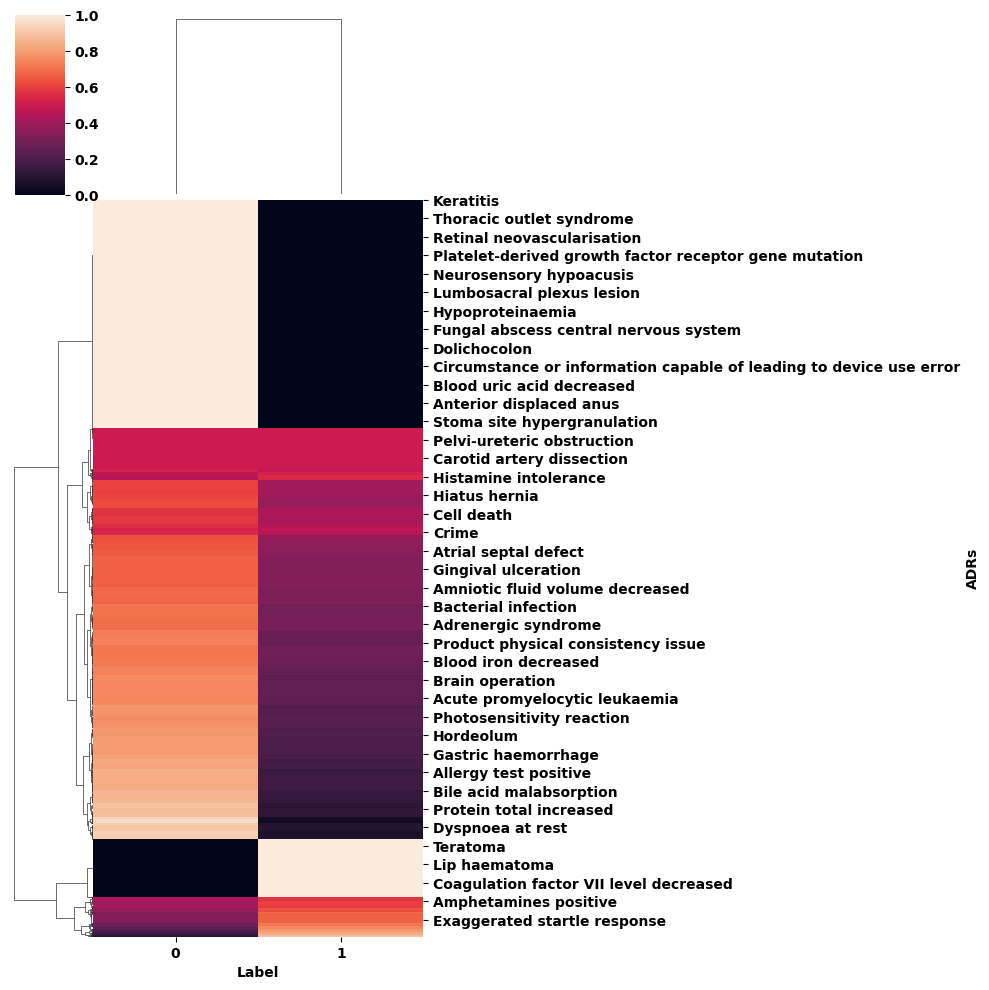

In [9]:
df_clustered = df_prr_drugs.groupby(['pt', 'Label'])["prr"].sum().reset_index()
df_filled = df_clustered.fillna(0.0)  

result = df_clustered.pivot(index='pt', columns='Label', values='prr')
result.fillna(0, inplace=True)

ax = sns.heatmap(result)
ax.set_ylabel("ADRs")

plt.savefig("./img/heatmap_adr_clusters.png", bbox_inches='tight')
g = sns.clustermap(result, yticklabels= "auto")
g.ax_heatmap.set_ylabel("ADRs")

plt.savefig("./img/clustermap_adr_clusters.png", bbox_inches='tight')
df_clustered.to_csv("./data/cluster_ADR.csv", index=False)
plt.show()

To predict ADRs, we will need PRRs of an ADR with spread, so we can use it with linear regression. In this case, "depression" had the best spread of values. 

In [10]:

df_prr_mean_std = dd.read_csv("prr.csv/*.part", usecols=['pt', 'prod_ai','prr'])
df_prr_mean_std = df_prr_mean_std.groupby('pt')['prr'].mean().reset_index().rename(columns={'prr': 'mean_column'}).merge(df_prr_mean_std, on='pt', how='inner')
df_prr_mean_std = df_prr_mean_std.groupby('pt')['prr'].std().reset_index().rename(columns={'prr': 'std_column'}).merge(df_prr_mean_std, on='pt', how='inner')
df_prr_mean_std = df_prr_mean_std.groupby(['pt'])['prod_ai'].nunique().reset_index().rename(columns={'prod_ai': 'unique_drugs'}).merge(df_prr_mean_std, on='pt', how='inner')
df_prr_mean_std = df_prr_mean_std.drop(['prr', 'prod_ai'], axis=1)
df_prr_mean_std = df_prr_mean_std.drop_duplicates()
df_prr_mean_std.compute()
df_b = df_prr_mean_std.fillna(0.0)
list_adr = df_b["pt"].compute().to_list()

df_prr_mean_std = df_prr_mean_std.sort_values(by="unique_drugs", ascending=False)

df_prr_mean_std.to_csv("./data/ADR_mean_std.csv", index=False)



['c:\\Users\\allan\\OneDrive\\Documentos\\ISC10A\\INMEGEN\\First_Project\\FAERS-Antidepressants-ADR\\data\\ADR_mean_std.csv\\00.part',
 'c:\\Users\\allan\\OneDrive\\Documentos\\ISC10A\\INMEGEN\\First_Project\\FAERS-Antidepressants-ADR\\data\\ADR_mean_std.csv\\01.part',
 'c:\\Users\\allan\\OneDrive\\Documentos\\ISC10A\\INMEGEN\\First_Project\\FAERS-Antidepressants-ADR\\data\\ADR_mean_std.csv\\02.part',
 'c:\\Users\\allan\\OneDrive\\Documentos\\ISC10A\\INMEGEN\\First_Project\\FAERS-Antidepressants-ADR\\data\\ADR_mean_std.csv\\03.part',
 'c:\\Users\\allan\\OneDrive\\Documentos\\ISC10A\\INMEGEN\\First_Project\\FAERS-Antidepressants-ADR\\data\\ADR_mean_std.csv\\04.part',
 'c:\\Users\\allan\\OneDrive\\Documentos\\ISC10A\\INMEGEN\\First_Project\\FAERS-Antidepressants-ADR\\data\\ADR_mean_std.csv\\05.part',
 'c:\\Users\\allan\\OneDrive\\Documentos\\ISC10A\\INMEGEN\\First_Project\\FAERS-Antidepressants-ADR\\data\\ADR_mean_std.csv\\06.part',
 'c:\\Users\\allan\\OneDrive\\Documentos\\ISC10A\\INMEG

In this case, we also created a heatmap, by removing the cases where prr == 1.0, just to see if there are some changes in the clustering if we exclude specific cases where the ADR is only reported for a single drug.
There are 2410 ADRs that were reported for only one drug. 

In this cell, we also saved the data for linear regression model (depression prr) in variable y for later use. 



SHAPE without norm 9581
SHAPE with norm 7171


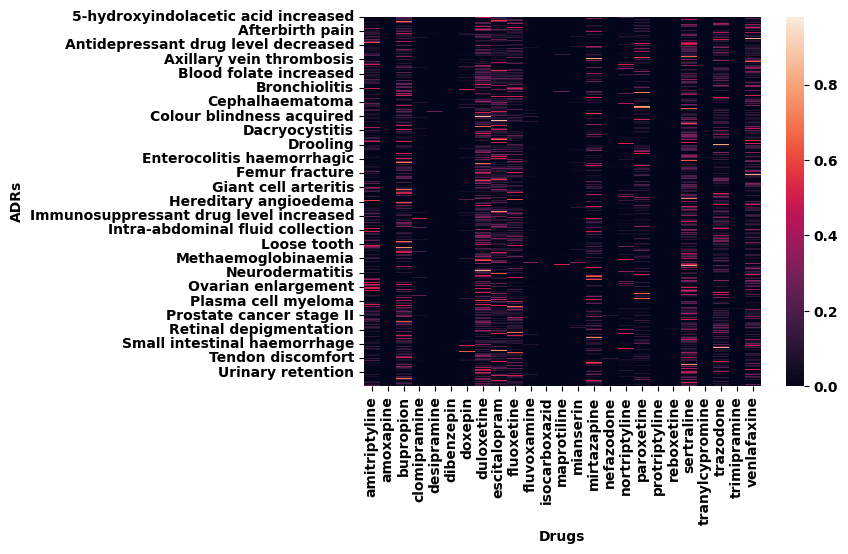

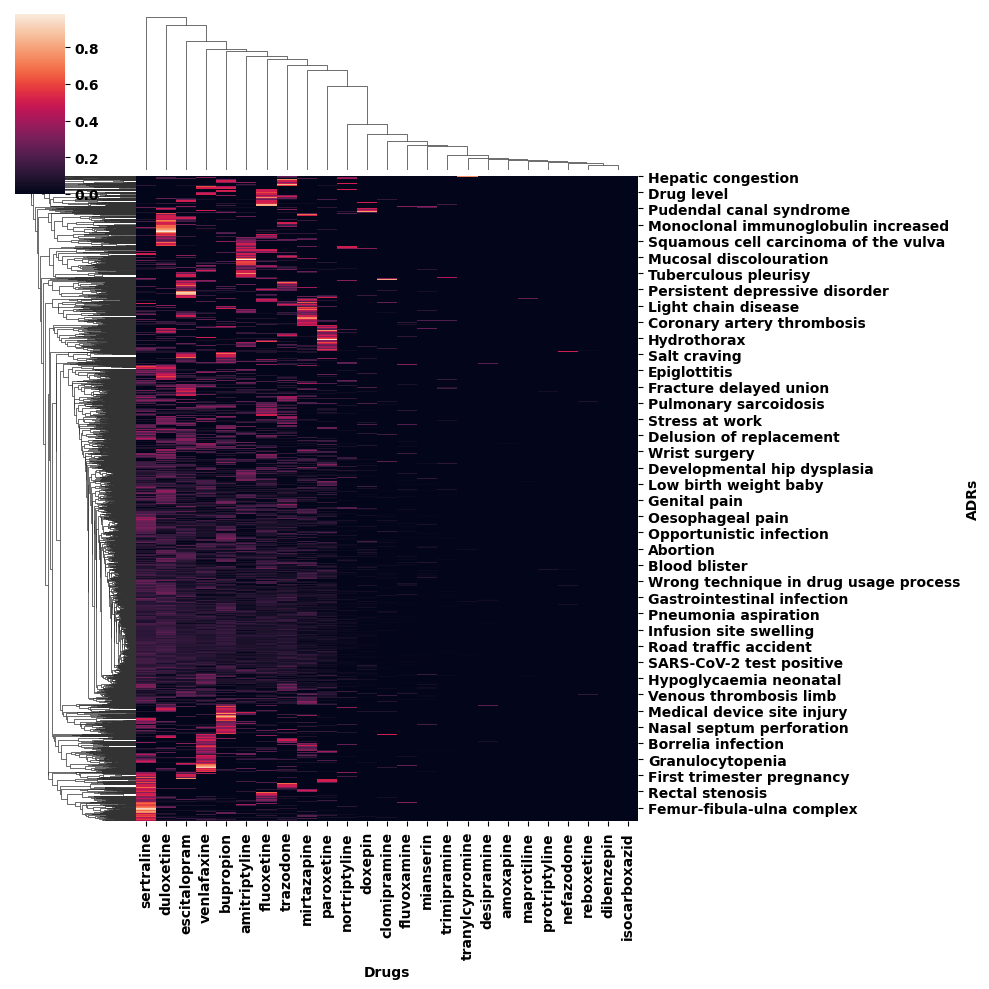

In [11]:

df_prr = dd.read_csv("prr.csv/*.part", usecols=['pt', 'prod_ai','prr'])
df_names = dd.from_pandas(classification_chemicals)
df_drug_prr = dd.merge(df_names, df_prr, on='prod_ai', how='inner')
df_norm = df_drug_prr.query("`prr` < 1.0").compute()
result_norm = df_norm.pivot(index='pt', columns='prod_ai', values='prr')
result_norm.fillna(0, inplace=True)

ax = sns.heatmap(result_norm)
ax.set_ylabel("ADRs")
ax.set_xlabel("Drugs")
plt.savefig("./img/heatmap_adr_drugs_norm.png", bbox_inches='tight')
g = sns.clustermap(result_norm)
g.ax_heatmap.set_ylabel("ADRs")
g.ax_heatmap.set_xlabel("Drugs")
plt.savefig("./img/clustermap_adr_drugs_norm.png", bbox_inches='tight')

df10 = df_drug_prr.compute()
print(f"SHAPE without norm {df10['pt'].unique().shape[0]}")
print(f"SHAPE with norm {df_norm['pt'].unique().shape[0]}")


filtered = df_prr.query("pt == 'Depression'").compute()

df_depression = table_Antidepressants.merge(filtered, how="left", left_on = "Name", right_on="prod_ai")
df_depression = df_depression.drop(["Isomeric", "Canonical", "pt"], axis=1)
df_depression = df_depression.fillna(0.0)


y = df_depression["prr"]


 We also generated two documents to visualize the prr mean and std of the ADRs of their respective clusters, to see if there are anomalies in the data between clusters. 

In [12]:

c0_std = df_norm.query("`Label` == 0")
c1_std = df_norm.query("`Label` == 1")


c0_std = c0_std.groupby('pt')['prr'].mean().reset_index().rename(columns={'prr': 'mean_column'}).merge(c0_std, on='pt', how='inner')
c0_std = c0_std.groupby('pt')['prr'].std().reset_index().rename(columns={'prr': 'std_column'}).merge(c0_std, on='pt', how='inner')
c0_std = c0_std.groupby(['pt'])['prod_ai'].nunique().reset_index().rename(columns={'prod_ai': 'unique_drugs'}).merge(c0_std, on='pt', how='inner')
c0_std = c0_std.drop(['prr', 'prod_ai', 'Label'], axis=1)
c0_std = c0_std.drop_duplicates()
print(c0_std.head())
c0_std = c0_std.sort_values(by="unique_drugs", ascending=False)
c0_std.to_csv("./data/C0_std.csv", index= False)

c1_std = c1_std.groupby('pt')['prr'].mean().reset_index().rename(columns={'prr': 'mean_column'}).merge(c1_std, on='pt', how='inner')
c1_std = c1_std.groupby('pt')['prr'].std().reset_index().rename(columns={'prr': 'std_column'}).merge(c1_std, on='pt', how='inner')
c1_std = c1_std.groupby(['pt'])['prod_ai'].nunique().reset_index().rename(columns={'prod_ai': 'unique_drugs'}).merge(c1_std, on='pt', how='inner')
c1_std = c1_std.drop(['prr', 'prod_ai', 'Label'], axis=1)
c1_std = c1_std.drop_duplicates()
c1_std = c1_std.sort_values(by="unique_drugs", ascending=False)
print(c1_std.head())
c1_std.to_csv("./data/C1_std.csv", index= False)


                                    pt  unique_drugs  std_column  mean_column
0  5-hydroxyindolacetic acid increased             1         NaN     0.666667
1                    5q minus syndrome             3    0.192450     0.277778
4          ADAMTS13 activity decreased             4    0.073648     0.173077
8                AIDS dementia complex             1         NaN     0.333333
9                 AIDS related complex             2    0.271964     0.269231
                            pt  unique_drugs  std_column  mean_column
4567                Depression             6    0.083805     0.066790
12584    Stress cardiomyopathy             6    0.131457     0.095238
1225                   Anxiety             6    0.060913     0.056839
2294   Blood glucose increased             6    0.045427     0.042811
573              Adverse event             6    0.048286     0.045716


Here, we check the data (that removed ADRs specific to only one drug), and check the probabilities of ADRs occurring. 

Most possible ADRs
7083
5956
0.9877283502998188
0.8305675637986334
High probability ADRs
2996
353
0.41779389206526285
0.04922604936549993
Possibility of ocurring in either cluster
1328
0.18519035002091758


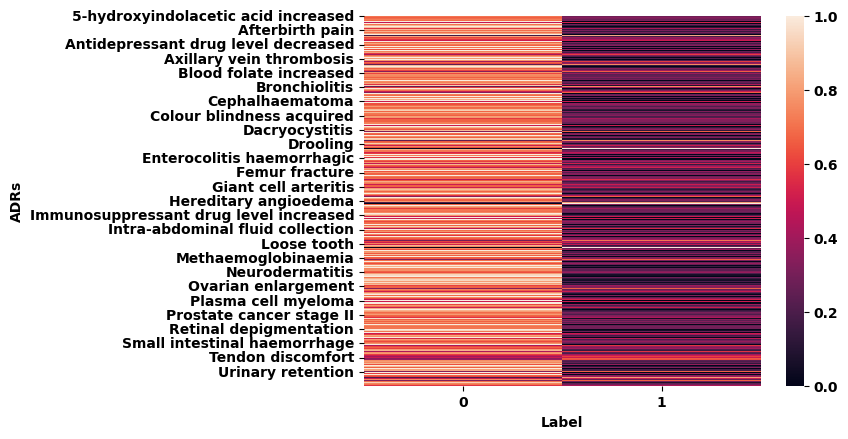

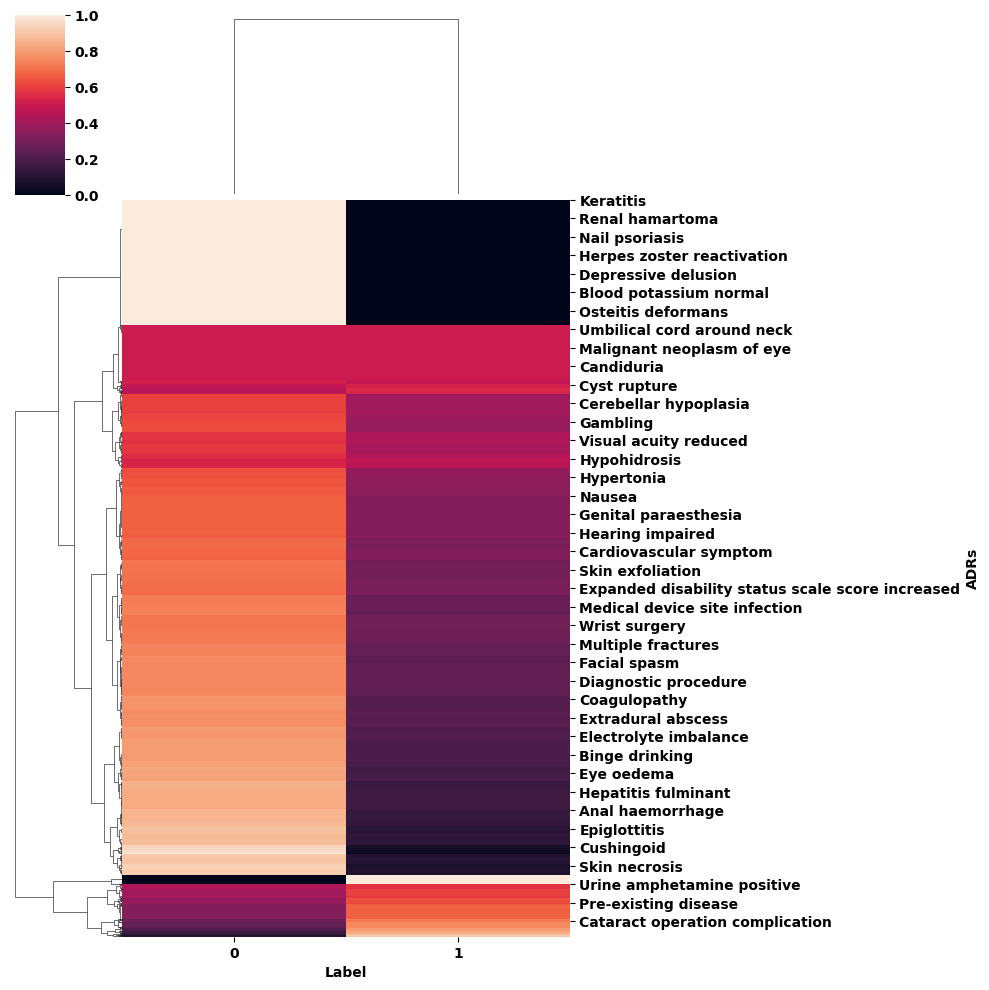

In [13]:


df_norm_label = df_norm.groupby(['pt', 'Label'])["prr"].sum().reset_index()

df_norm_label = df_norm_label.fillna(0.0) 
result_norm_label = df_norm_label.pivot(index='pt', columns='Label', values='prr')
result_norm_label.fillna(0, inplace=True)
df_c0 = df_norm_label.query("`Label` == 0")

df_c1 = df_norm_label.query("`Label` == 1")
unique_pt = df_norm_label["pt"].unique().shape[0]
print("Most possible ADRs")
print(df_c0.shape[0])
print(df_c1.shape[0])

print(df_c0.shape[0]/unique_pt)
print(df_c1.shape[0]/unique_pt)


df_c0 = df_norm_label.query("`prr` >= 0.6 & `prr` < 0.8 & `Label` == 0")

df_c1 = df_norm_label.query("`prr` >= 0.6 & `prr` < 0.8 & `Label` == 1")
common_ADR = pd.concat([df_c0, df_c1])["pt"].unique().shape[0]
print("High probability ADRs")
print(df_c0.shape[0])
print(df_c1.shape[0])

print(df_c0.shape[0]/unique_pt)
print(df_c1.shape[0]/unique_pt)


df_c0 = df_norm_label.query("`prr` >= 0.4 & `prr` < 0.6 & `Label` == 0")

df_c1 = df_norm_label.query("`prr` >= 0.4 & `prr` < 0.6 & `Label` == 1")
common_ADR = pd.concat([df_c0, df_c1])["pt"].unique().shape[0]
print("Possibility of ocurring in either cluster")
print(common_ADR)

print(common_ADR/unique_pt)

ax = sns.heatmap(result_norm_label)
ax.set_ylabel("ADRs")
ax.set_xlabel("Label")
plt.savefig("./img/heatmap_adr_cluster_norm.png", bbox_inches='tight')
g = sns.clustermap(result_norm_label)
g.ax_heatmap.set_ylabel("ADRs")
g.ax_heatmap.set_xlabel("Label")
plt.savefig("./img/clustermap_adr_cluster_norm.png", bbox_inches='tight')


We used linear regression to check the best n (n=26) for the dimensions of Graph2Vec (commented section), as it showed the best R2 and the least mean_absolute_error, without having colinearity. 
 y is the vector of prr (Drug, Depression).
 
<table>
    <tr>
        <th>variable name</th>
        <th>type</th>
        <th>Explanation</th>
    </tr>
    <tr>
        <td>y</td>
        <td>list(float)</td>
        <td>List of prr of Depression, considering 28 dimensions as antidepressants</td>
    </tr>
    <tr>
        <td>x_1</td>
        <td>list(numpy.ndarray(dtype=float))</td>
        <td>List of graph embeddings of 28 antidepressants</td>
    </tr>
</table>

In [13]:

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
max = 0
number = 0

import statsmodels.api as sm
#max = 0.0
#number = 0.0
#for i in range (1, 100):
#    g_mdl = Graph2Vec(dimensions=i)
#    g_mdl.fit(Graphs)
#    x_1 = g_mdl.get_embedding()
#    model = sm.OLS(y, x_1)
#    results = model.fit()
#    if max == 0.0:
#        max = results.rsquared_adj
#        number = i
#    if max < results.rsquared_adj:
#        max = results.rsquared_adj
#        number = i
model = sm.OLS(y, x_1)
results = model.fit()
print(results.summary())



                                 OLS Regression Results                                
Dep. Variable:                    prr   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.898
Method:                 Least Squares   F-statistic:                              10.50
Date:                Thu, 18 Jul 2024   Prob (F-statistic):                      0.0905
Time:                        13:42:27   Log-Likelihood:                          104.36
No. Observations:                  28   AIC:                                     -156.7
Df Residuals:                       2   BIC:                                     -122.1
Df Model:                          26                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

We searched for the best parameters of the xgboost model using depression prr as the 'y' variable. 
<table>
    <tr>
        <th>variable name</th>
        <th>type</th>
        <th>Explanation</th>
    </tr>
    <tr>
        <td>y</td>
        <td>list(float)</td>
        <td>List of prr of Depression, considering 28 dimensions as antidepressants</td>
    </tr>
    <tr>
        <td>x_1</td>
        <td>list(numpy.ndarray(dtype=float))</td>
        <td>List of graph embeddings of 28 antidepressants</td>
    </tr>
</table>

In [ ]:

from sklearn.model_selection import GridSearchCV, LeaveOneOut
import xgboost as xgb


params={"learning_rate": (0.05, 0.10, 0.15),
        "max_depth": [ 3, 4, 5, 6, 8],
                        "min_child_weight": [ 1, 3, 5, 7],
                        "gamma":[ 0.0, 0.1, 0.2],
                        "colsample_bytree":[ 0.3, 0.4],},

model = xgb.XGBRegressor(objective="reg:squarederror")
grid_search = GridSearchCV(estimator=model, param_grid=params, scoring='neg_mean_absolute_error', refit=False, cv=LeaveOneOut())
grid_search.fit(x_1, y)
print(grid_search.best_params_)
best_params = grid_search.best_params_

{'colsample_bytree': 0.3, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5}


<table>
    <tr>
        <th>variable name</th>
        <th>type</th>
        <th>Explanation</th>
    </tr>
    <tr>
        <td>table_Antidepressants</td>
        <td>dataframe
        {</br>
            &emsp;"Name": str</br>
            &emsp;"Isomeric": str</br>
            &emsp;"Canonical": str</br>
        }
        </td>
        <td>Dataframe with basic information of 28 antidepressants: name of drug and smiles (isomeric, canonical)</td>
    </tr>
    <tr>
        <td>x_1</td>
        <td>list(numpy.ndarray(dtype=float))</td>
        <td>List of graph embeddings of 28 antidepressants</td>
    </tr>
    <tr>
        <td>df_prr</td>
        <td>dataframe
        {</br>
            &emsp;"prod_ai": str, antidepressant's name</br>
            &emsp;"pt": str, Adverse Drug reaction in preferred terms (MEDRA)</br>
            &emsp;"no_reactions": int, number of reports done for that ADR and drug</br>
            &emsp;"total": int, number of reports done in total for that ADR considering all the antidepressants</br>
            &emsp;"prr": float, PRR for that ADR and antidepressant</br>
        }
        </td>
        <td>Dataframe with information of the relation between each drug and its ADR</td>
    </tr>
</table>

In [15]:
from sklearn.model_selection import StratifiedKFold

from scipy.stats import uniform, randint, zscore

from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split, LeaveOneOut
import xgboost as xgb
import concurrent.futures as futures
from sklearn.ensemble import RandomForestRegressor
dict_score = {"pt": [], "mean_mae_xgboost": [], "std_mae_xgboost": [], "z_mae_xgboost": []}

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", colsample_bytree = 0.3, gamma= 0.0, learning_rate= 0.1, max_depth = 3, min_child_weight= 5, random_state=42)

def reac_data(adr):
    filtered = df_prr.query(f'pt == "{adr}"').compute()
    df_8 = table_Antidepressants.merge(filtered, how="left", left_on= "Name", right_on="prod_ai")
    df_8 = df_8.fillna(0.0)
    y = df_8["prr"]
    
    scores_mae_xgboost = []
    leaf_scores = []
    for train_index, test_index in loo.split(x_1):   
        X_train, X_test = x_1[train_index], x_1[test_index]
        y_train, y_test = y[train_index], y[test_index]
        xgb_model.fit(X_train, y_train)

        y_pred_xgboost = xgb_model.predict(X_test)
        scores_mae_xgboost.append(median_absolute_error(y_test, y_pred_xgboost))

        
    dict_score["pt"].append(adr)
    dict_score["mean_mae_xgboost"].append(np.mean(scores_mae_xgboost))
    dict_score["std_mae_xgboost"].append(np.std(scores_mae_xgboost))
    dict_score["z_mae_xgboost"].append(zscore(scores_mae_xgboost, nan_policy ='omit'))
    return f"Finish {adr}"

loo = LeaveOneOut()  
with futures.ThreadPoolExecutor() as e:
    f = [e.submit(reac_data, adr) for adr in list_adr]
    for r in futures.as_completed(f):
        print(r.result())
   
df_score_xgboost = pd.DataFrame(dict_score)
df_score_xgboost = df_score_xgboost.sort_values("mean_mae_xgboost", ascending= True)

print(df_score_xgboost.head(15))
df_score_xgboost.to_csv("./data/score_xgboost.csv", index= False)


Finish Albumin globulin ratio abnormal
Finish 5'nucleotidase increased
Finish Abnormal labour
Finish Acute encephalitis with refractory, repetitive partial seizures
Finish Abortion spontaneous incomplete
Finish Adenocarcinoma
Finish Acute right ventricular failure
Finish Alcohol withdrawal syndrome
Finish Administration site swelling
Finish Air embolism
Finish Acute kidney injury
Finish Allergic oedema
Finish Amphetamines
Finish Amniorrhoea
Finish Aortic anastomosis
Finish Anal abscess
Finish Anaplastic astrocytoma
Finish Androgen deficiency
Finish Antithrombin III decreased
Finish Anaplastic large-cell lymphoma
Finish Angiosarcoma
Finish Aortic rupture
Finish Aortic thrombosis
Finish Aortic valve stenosis
Finish Argininosuccinate synthetase deficiency
Finish Application site ulcer
Finish Arm amputation
Finish Arthroscopic surgery
Finish Arterial spasm
Finish Astigmatism
Finish Atypical mycobacterial infection
Finish Auricular swelling
Finish Autoimmune neutropenia
Finish Autoimmune pa

In [ ]:
from sklearn.model_selection import StratifiedKFold

from scipy.stats import uniform, randint

from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split, LeaveOneOut
import xgboost as xgb
import concurrent.futures as futures
from sklearn.ensemble import RandomForestRegressor

params_random = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1,2,4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
}

rf_model = RandomForestRegressor()
model = GridSearchCV(estimator= rf_model, param_grid= params_random, scoring='neg_mean_absolute_error', refit=False, cv=LeaveOneOut())
model.fit(x_1, y)
print(model.best_params_)
best_params_rf = model.best_params_

{'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10}


In [16]:
from sklearn.model_selection import StratifiedKFold

from scipy.stats import uniform, randint, zscore

from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, mean_absolute_error, f1_score, cohen_kappa_score, median_absolute_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split, LeaveOneOut
import xgboost as xgb
import concurrent.futures as futures
from sklearn.ensemble import RandomForestRegressor

dict_score_rf = {"pt": [], "mean_mae_rf": [], "std_mae_rf": [], "z_mae_rf": []}

rf_model = RandomForestRegressor(bootstrap = False, max_depth = 20, max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 5, n_estimators = 10, random_state=42)
print("Starting model")
def reac_data(adr):
    filtered = df_prr.query(f'pt == "{adr}"').compute()
    df_8 = table_Antidepressants.merge(filtered, how="left", left_on="Name", right_on="prod_ai")
    df_8 = df_8.fillna(0.0)
    y = df_8["prr"]
    
    
    scores_mae_rf = []
    for train_index, test_index in loo.split(x_1):   
        X_train, X_test = x_1[train_index], x_1[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rf_model.fit(X_train, y_train)
        
        #y_pred_xgboost = model.predict(X_test, pred_leaf=True)
        
        y_pred_rf = rf_model.predict(X_test)
        scores_mae_rf.append(median_absolute_error(y_test, y_pred_rf))

        
    dict_score_rf["pt"].append(adr)    
    dict_score_rf["mean_mae_rf"].append(np.nanmean(scores_mae_rf))
    dict_score_rf["std_mae_rf"].append(np.nanstd(scores_mae_rf))
    dict_score_rf["z_mae_rf"].append(zscore(scores_mae_rf, nan_policy ='omit'))
    return f"Finish {adr}"

loo = LeaveOneOut()  
for adr in list_adr:
    reac_data(adr)
df_rf = pd.DataFrame(dict_score_rf)
df_rf = df_rf.sort_values("mean_mae_rf", ascending= True)
df_rf.to_csv("./data/score_rf.csv", index= False)


Starting model


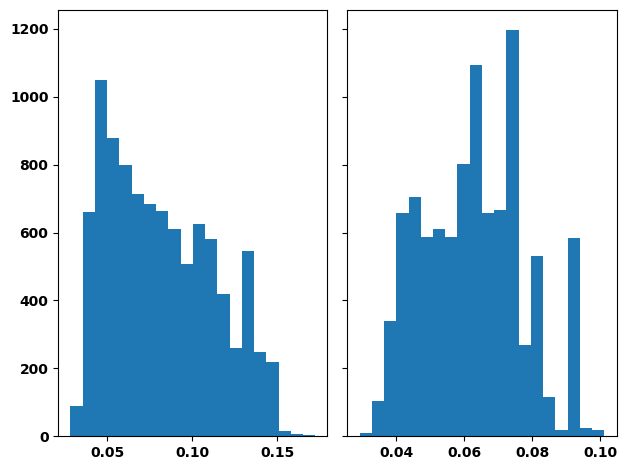

In [17]:
N_points = 100000
n_bins = 20

df_score_xgboost = pd.read_csv("./data/score_xgboost.csv")
df_rf = pd.read_csv("./data/score_rf.csv")
# Generate two normal distributions
dist1 = df_score_xgboost["mean_mae_xgboost"]
dist2 = df_rf["mean_mae_rf"]

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(dist1, bins=n_bins)
axs[1].hist(dist2, bins=n_bins)


plt.show()

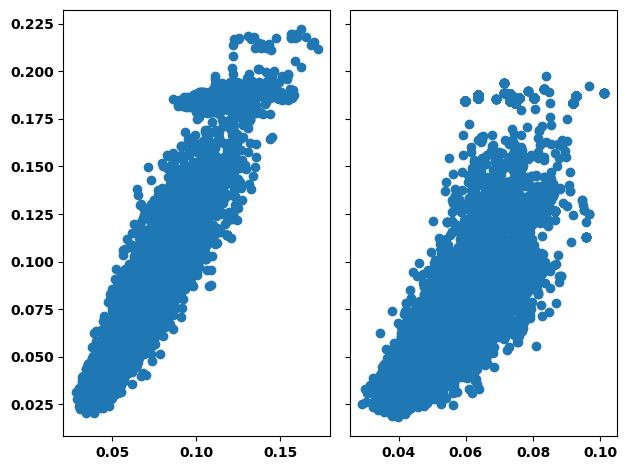

In [18]:
N_points = 100000
# Generate two normal distributions
dist1_x = df_score_xgboost["mean_mae_xgboost"]
dist1_y = df_score_xgboost["std_mae_xgboost"]
dist2_x = df_rf["mean_mae_rf"]
dist2_y = df_rf["std_mae_rf"]

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs[0].scatter(dist1_x, dist1_y)
axs[1].scatter(dist2_x, dist2_y)


plt.show()

In [19]:
from scipy.stats import uniform, randint, zscore
zscore_xgboost = zscore(dist1_x)
zscore_rf = zscore(dist2_x)



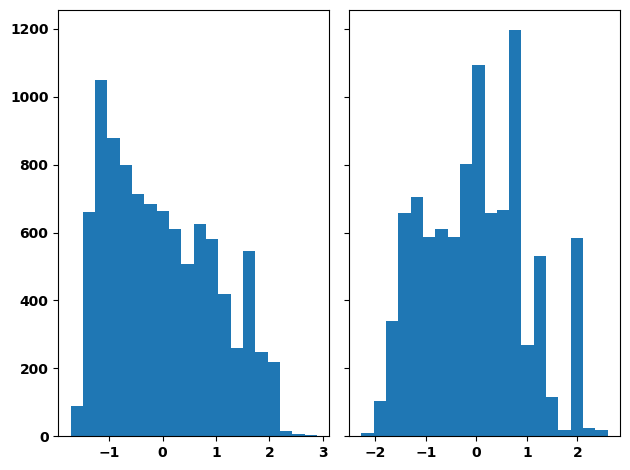

In [20]:
N_points = 100000
n_bins = 20

# Generate two normal distributions
dist1 = zscore_xgboost
dist2 = zscore_rf

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(dist1, bins=n_bins)
axs[1].hist(dist2, bins=n_bins)


plt.show()

In [21]:
import xgboost as xgb
import concurrent.futures as futures
import pandas as pd
df_xgboost = pd.read_csv("./data/score_xgboost.csv")

filtered_xgboost = df_xgboost.query("mean_mae_xgboost <= 0.05 & std_mae_xgboost <=0.05")
print(filtered_xgboost.shape[0])
filtered_xgboost = filtered_xgboost.sort_values(by=["pt"]).reset_index(drop=True).drop(["mean_mae_xgboost", "std_mae_xgboost", "z_mae_xgboost"], axis=1)
filtered_xgboost = filtered_xgboost.rename_axis("index_pt").reset_index()
filtered_xgboost.to_csv("./data/ordered_xgboost.csv", index=False)
adr_xgboost = filtered_xgboost["pt"].to_list()

from scipy.stats import uniform, randint, zscore
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split, LeaveOneOut, cross_validate

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", colsample_bytree = 0.3, gamma= 0.0, learning_rate= 0.1, max_depth = 3, min_child_weight= 5, random_state=42)

def reac_data(adr):
    filtered = df_prr.query(f'pt == "{adr}"').compute()
    df_8 = table_Antidepressants.merge(filtered, how="left", left_on="Name", right_on="prod_ai")
    df_8 = df_8.fillna(0.0)
    y = df_8["prr"]
    output = cross_validate(xgb_model, x_1, y, cv=LeaveOneOut(), scoring='neg_mean_absolute_error', return_estimator =True)
    for idx,estimator in enumerate(output['estimator']):
        feature_importances = pd.DataFrame(estimator.feature_importances_,
                                            columns=['importance'])
        feature_importances["pt"] = adr
        feature_importances = feature_importances.rename_axis('feature').reset_index()
    return feature_importances

all_importance = []  
with futures.ThreadPoolExecutor() as e:
    f = [e.submit(reac_data, adr) for adr in adr_xgboost]
    for r in futures.as_completed(f):
        all_importance.append(r.result())
df_importance= pd.concat(all_importance)
df_importance.to_csv("./data/xgboost_importance.csv", index= False)


1560


In [22]:

df_rf = pd.read_csv("./data/score_rf.csv")
dict_score_rf = {"pt": [], "mean_mae_rf": [], "std_mae_rf": [], "z_mae_rf": []}



filtered_rf = df_rf.query("mean_mae_rf <= 0.05 & std_mae_rf <=0.05")
print(filtered_rf.shape[0])
filtered_rf.sort_values(by=["pt"])["pt"].to_list()
filtered_rf = filtered_rf.sort_values(by=["pt"]).reset_index(drop=True).drop(["mean_mae_rf", "std_mae_rf", "z_mae_rf"], axis=1)
filtered_rf = filtered_rf.rename_axis("index_pt").reset_index()
filtered_rf.to_csv("./data/ordered_rf.csv", index=False)
adr_rf = filtered_rf["pt"].to_list()


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import LeaveOneOut, cross_validate

rf_model = RandomForestRegressor(bootstrap = False, max_depth = 20, max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 5, n_estimators = 10, random_state=42)
def reac_data(adr):
    filtered = df_prr.query(f'pt == "{adr}"').compute()
    df_8 = table_Antidepressants.merge(filtered, how="left", left_on="Name", right_on= "prod_ai")
    df_8 = df_8.fillna(0.0)
    y = df_8["prr"]
    output = cross_validate(xgb_model, x_1, y, cv=LeaveOneOut(), scoring='neg_mean_absolute_error', return_estimator =True)
    for idx,estimator in enumerate(output['estimator']):
        feature_importances = pd.DataFrame(estimator.feature_importances_,
                                            columns=['importance'])
        feature_importances["pt"] = adr
        feature_importances = feature_importances.rename_axis('feature').reset_index()
    return feature_importances

all_importance_rf = []  
for adr in adr_rf:
    result_rf = reac_data(adr)
    all_importance_rf.append(result_rf)
df_importance_rf= pd.concat(all_importance_rf)

df_importance_rf.to_csv("./data/rf_importance.csv", index= False)

1845


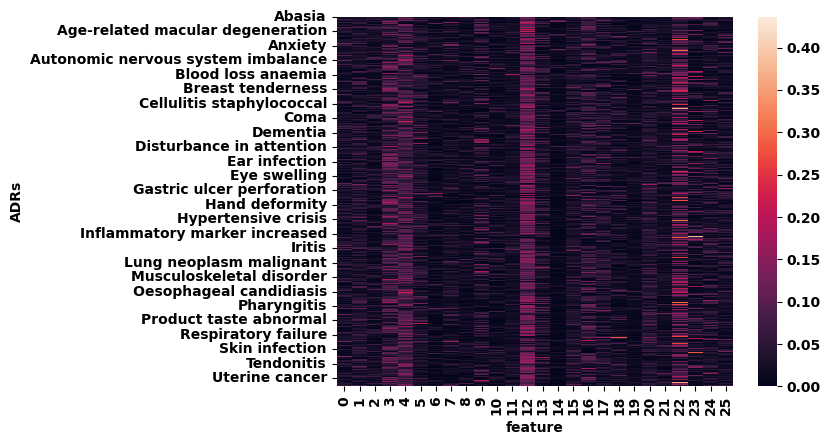

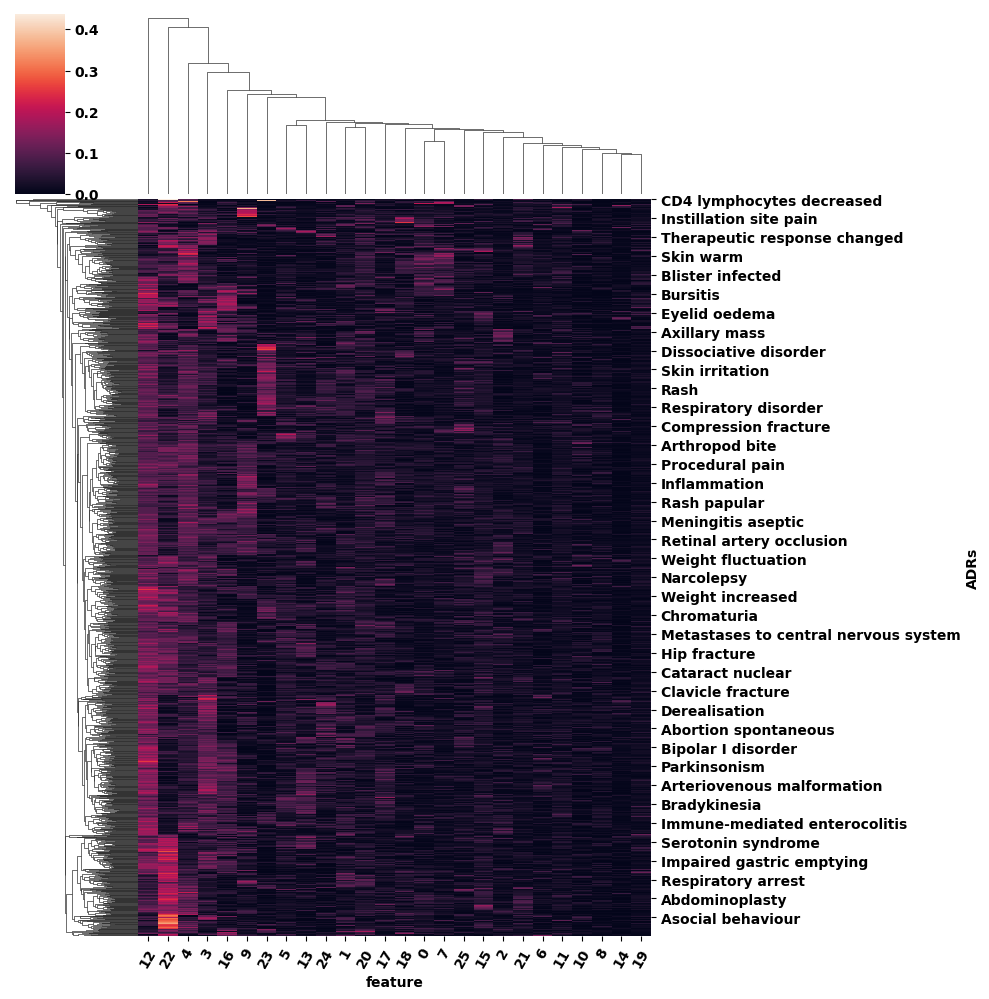

In [23]:
#

import pandas as pd
import seaborn as sns
df_importance = pd.read_csv("./data/xgboost_importance.csv")
result_importance = df_importance.pivot(index='pt', columns='feature', values='importance')
ax = sns.heatmap(result_importance , yticklabels= "auto")
ax.set_ylabel("ADRs")
g = sns.clustermap(result_importance, yticklabels="auto")
dendogram_xg = g.dendrogram_row.calculated_linkage
g.ax_heatmap.set_ylabel("ADRs")
g.ax_heatmap.tick_params(axis='x', rotation=60)

plt.show()



In [32]:

from scipy.cluster import hierarchy

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(100, 400))

dn = hierarchy.dendrogram(dendogram_xg, orientation='left', color_threshold=.22)



df_linkage = pd.DataFrame(dendogram_xg)

plt.axvline(x=.20, c='k')
plt.axvline(x=.15, c='k')
plt.axvline(x=.10, c='k') 
plt.axvline(x=.05, c='k')
plt.show()

In [55]:
import pandas as pd
import numpy as np
df_ordered_xg = pd.read_csv("./data/ordered_xgboost.csv")

fcluster_xg_25 = hierarchy.fcluster(dendogram_xg, criterion="distance", t=0.22)
df_fcluster_xg_25 = pd.DataFrame({"cluster": fcluster_xg_25})
df_fcluster_xg_25= df_fcluster_xg_25.rename_axis("index_pt").reset_index()
df_fcluster_xg_25 = df_fcluster_xg_25.merge(df_ordered_xg, how="left", on="index_pt")
df_fcluster_xg_25.to_csv("./data/xgboost_fcluster_25.csv", index=False)
cluster_no_25 = int(df_fcluster_xg_25.query("`pt` == 'Asocial behaviour'").iloc[0]["cluster"])

df_cluster_25 = df_fcluster_xg_25.query(f"`cluster` == {cluster_no_25}")
print(f"Quantity of ADR in cluster {cluster_no_25} with 'Asocial behaviour': {df_cluster_25.shape[0]}")


Quantity of ADR in cluster 28 with 'Asocial behaviour': 194


In [57]:

df_cluster_xg= pd.read_csv("./data/xgboost_fcluster_25.csv")
df_importance_xg = pd.read_csv("./data/xgboost_importance.csv")

cluster_xgboost_sig = int(df_cluster_xg.query("`pt` == 'Asocial behaviour'").iloc[0]["cluster"])
df_filter_cluster = df_cluster_xg.query(f"`cluster` == {cluster_xgboost_sig}")
df_cluster_importance = df_filter_cluster.merge(df_importance_xg, how="left", on="pt")

df_c_feature_22 = df_cluster_importance.query("`feature` == 22")
#print(df_c_feature_22)
mean_importance = df_c_feature_22["importance"].mean()
std_importance = df_c_feature_22["importance"].std()
print(f"Mean of importance, cluster {cluster_xgboost_sig}: {mean_importance}")
print(f"Standard deviation of importance, cluster {cluster_xgboost_sig}: {std_importance}")

Mean of importance, cluster 28: 0.15624676352432434
Standard deviation of importance, cluster 28: 0.04894862572531069


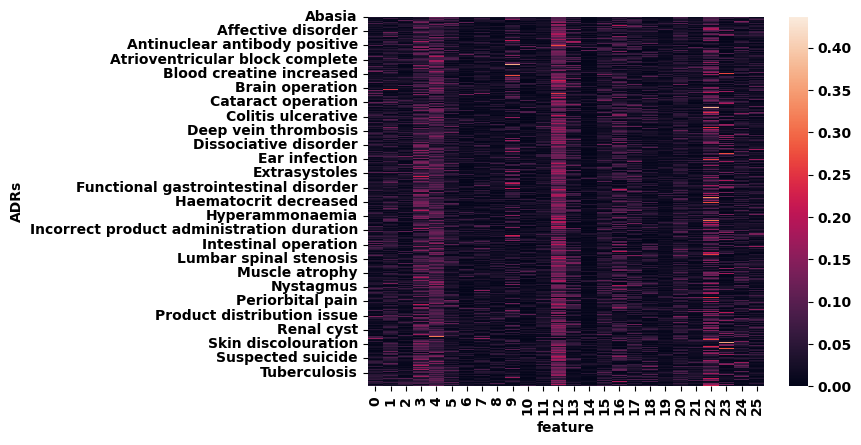

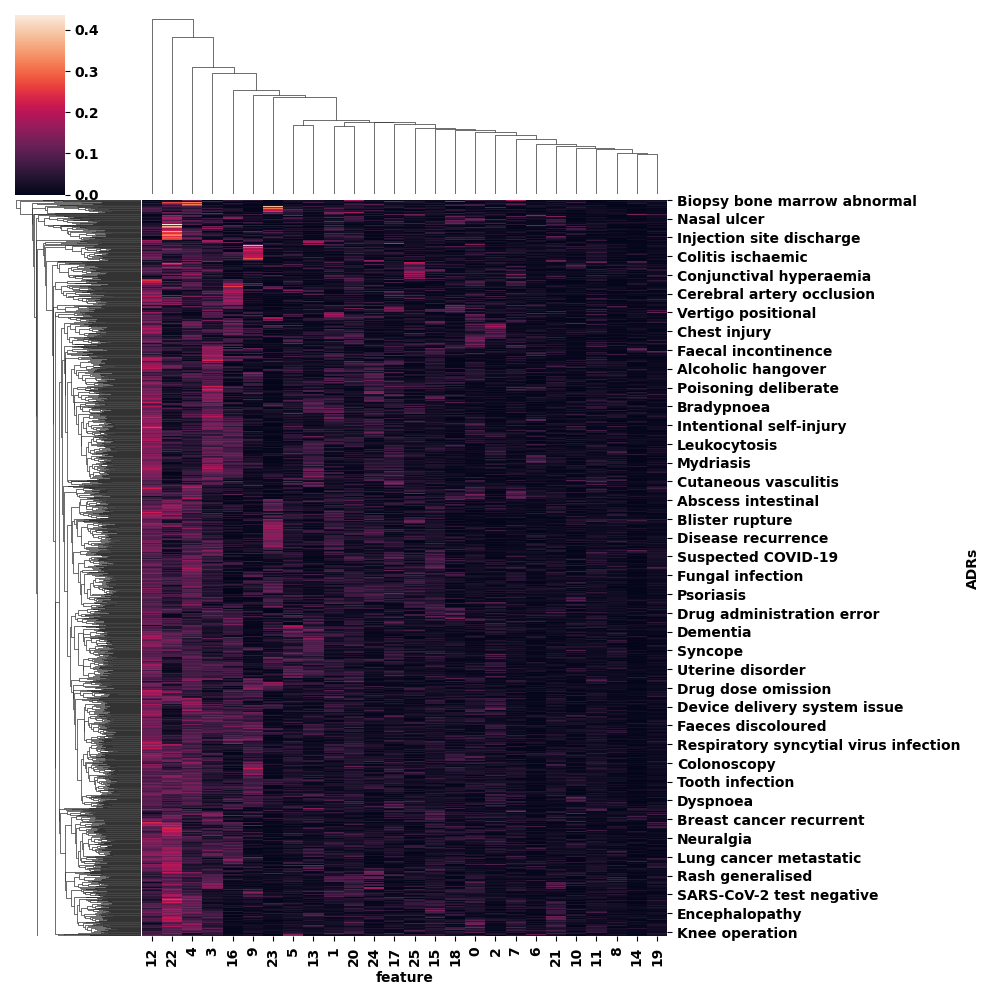

In [34]:
import pandas as pd
import seaborn as sns
df_importance_rf = pd.read_csv("./data/rf_importance.csv")
result_importance_rf = df_importance_rf.pivot(index='pt', columns='feature', values='importance')
ax = sns.heatmap(result_importance_rf , yticklabels="auto")
ax.set_ylabel("ADRs")
g = sns.clustermap(result_importance_rf, yticklabels="auto")
dendogram_rf = g.dendrogram_row.calculated_linkage
g.ax_heatmap.set_ylabel("ADRs")
g.ax_heatmap.tick_params(axis='x', rotation=90)

plt.show()


In [37]:
from scipy.cluster import hierarchy

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(100, 400))

dn_rf = hierarchy.dendrogram(dendogram_rf, orientation='left', color_threshold=.25)



df_linkage_rf = pd.DataFrame(dendogram_rf)
plt.axvline(x=.30, c='k')
plt.axvline(x=.25, c='k')
plt.axvline(x=.20, c='k')
plt.axvline(x=.15, c='k')
plt.axvline(x=.10, c='k') 
plt.axvline(x=.05, c='k')
plt.show()
df_linkage_rf.to_csv("linkage_rf.csv", index=False)

In [42]:
#Electrocardiogram QRS complex prolonged

import pandas as pd
import numpy as np

df_ordered_rf = pd.read_csv("./data/ordered_rf.csv")
fcluster_rf = hierarchy.fcluster(dendogram_rf, criterion="distance", t=0.27)

df_fcluster_rf = pd.DataFrame({"cluster": fcluster_rf })
df_fcluster_rf = df_fcluster_rf.rename_axis("index_pt").reset_index()
df_fcluster_rf = df_fcluster_rf.merge(df_ordered_rf, how="left", on="index_pt")


df_fcluster_rf.to_csv("./data/fcluster_rf.csv", index=False)

cluster_rf = int(df_fcluster_rf.query("`pt` == 'Nasal ulcer'").iloc[0]["cluster"])
df_cluster_rf = df_fcluster_rf.query(f"`cluster` == {cluster_rf}")
print(df_cluster_rf.shape)



(63, 3)


In [64]:

df_cluster_rf= pd.read_csv("./data/fcluster_rf.csv")
df_importance_rf = pd.read_csv("./data/rf_importance.csv")

cluster_rf_sig = int(df_cluster_rf.query("`pt` == 'Nasal ulcer'").iloc[0]["cluster"])

df_filter_cluster = df_cluster_rf.query(f"`cluster` == {cluster_rf_sig}")
df_cluster_importance = df_filter_cluster.merge(df_importance_xg, how="left", on="pt")

df_c_feature_22 = df_cluster_importance.query("`feature` == 22")
#print(df_c_feature_22)
mean_importance = df_c_feature_22["importance"].mean()
std_importance = df_c_feature_22["importance"].std()
print(f"Mean of importance, cluster {cluster_xgboost_sig}: {mean_importance}")
print(f"Standard deviation of importance, cluster {cluster_xgboost_sig}: {std_importance}")

Mean of importance, cluster 28: 0.17532069229999997
Standard deviation of importance, cluster 28: 0.052790465243816836


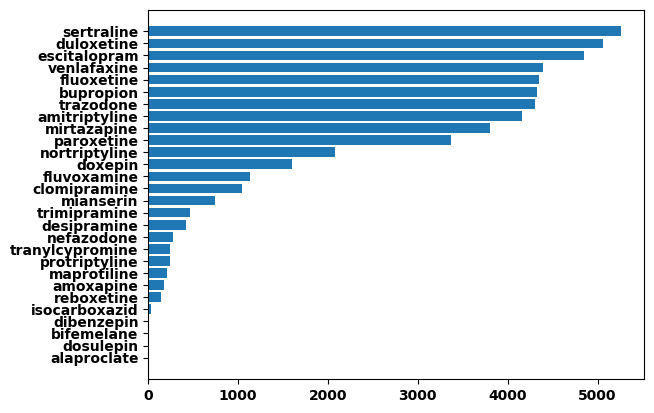

In [98]:
df_drug_reactions = pd.read_csv("drug_no_reactions.csv")

n_bins = 28

# Generate two normal distributions
plt.barh( df_drug_reactions["prod_ai"], df_drug_reactions["adrs"], )
plt.show()